<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Integrating Visual Document Intelligence with Voice Response with ColPali, Bedrock and Strands Agents
</h1>.

<p align="center">
  <img src="imgs/multimodal.png" alt="Multimodal Diagram">
</p>


In [1]:
import os
import torch
import qdrant_client
import time
import shutil
import base64
import ollama
import boto3

from io import BytesIO
from huggingface_hub import login
from colpali_engine.models import ColPali, ColPaliProcessor
from qdrant_client.http import models
from tqdm import tqdm 
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Markdown
from dotenv import load_dotenv
from pdf2image import convert_from_path

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
    Loading the PDF files (Dataset)
</h1>

In [2]:
# Create a directory to save the PDF files 
pdf_dir = "pdf_data"
os.makedirs(pdf_dir, exist_ok=True)

# Go to https://ncert.nic.in/textbook.php?jesc1=13-13 and download the PDF files and save them in the pdf_data directory 

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Load the ColPali Multimodal Document Retrieval Model
</h1>

In [3]:
# Load environment variables from .env file
load_dotenv()  

# Login using token from environment variable
login(token=os.getenv('HUGGING_FACE_TOKEN'))

In [4]:
# Check if CUDA/MPS/CPU is available
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"{device = }")

device = 'mps'


This code block does the following:

1. First, it defines the model name [`vidore/colpali-v1.3`](https://huggingface.co/vidore/colpali-v1.3) which is a pre-trained model hosted on the Hugging Face Hub.

2. Then it initializes two main components:

   a. The `ColPaliProcessor`: This is responsible for:
   - Processing and preparing images for the model
   - Tokenizing text inputs
   - Converting inputs into the format the model expects
   
   b. The `ColPali` model: This is the main multimodal model that:
   - Can handle both image and text inputs
   - Uses bfloat16 precision for memory efficiency
   - Automatically maps to the best available device (GPU/CPU/MPS)
   - Caches downloaded files locally to avoid re-downloading

Both components use the same model name and cache directory to ensure consistency and efficiency in loading the pre-trained weights and configurations.

In [5]:

model_name = "vidore/colpali-v1.3"

colpali_model = ColPali.from_pretrained(
                pretrained_model_name_or_path=model_name,
                torch_dtype=torch.bfloat16,
                device_map=device, 
                cache_dir="./model_cache"
            )

colpali_processor = ColPaliProcessor.from_pretrained(
                pretrained_model_name_or_path=model_name,
                cache_dir="./model_cache"
            )

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
    Setup vector database
</h1>

Now, open a terminal and run the following to setup the vector database

```
docker run -p 6333:6333 -p 6334:6334 \
    -v $(pwd)/qdrant_storage:/qdrant/storage:z \
    qdrant/qdrant
```

Once that is done, you can check the [Qdrant Dashboard](http://localhost:6333/dashboard#/welcome) locally



In [6]:
# Create a Qdrant client
client = qdrant_client.QdrantClient(
    host="localhost",
    port=6333
)

# Get the collection info
client.info()


VersionInfo(title='qdrant - vector search engine', version='1.13.4', commit='7abc684361fb81d8b62cf1554d8bf4fb65a706d7')

In [8]:
# Collection name
COLLECTION_NAME = "class_X_science"
VECTOR_SIZE = 128

# Check if collection exists
collections = client.get_collections().collections
collection_names = [collection.name for collection in collections]

if COLLECTION_NAME not in collection_names:
    # Create a collection only if it doesn't exist
    client.create_collection(
        collection_name=COLLECTION_NAME,
        on_disk_payload=True,
        vectors_config=models.VectorParams(
            size=VECTOR_SIZE,
            distance=models.Distance.COSINE,
            on_disk=True,
            multivector_config=models.MultiVectorConfig(
                comparator=models.MultiVectorComparator.MAX_SIM
            ),
        ),
    )
    print(f"Collection '{COLLECTION_NAME}' created successfully.")
else:
    print(f"Collection '{COLLECTION_NAME}' already exists.")

Collection 'class_X_science' created successfully.


Verify the collection [here](http://localhost:6333/dashboard#/collections)

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Store embeddings in vector database
</h1>

In [9]:
# Disable parallelism in tokenizers to prevent potential issues and improve stability, especially in environments with limited resources.
os.environ["TOKENIZERS_PARALLELISM"] = "false" 

# Wrapper function to convert PDFs into a dictionary of PIL images which will be used to create embeddings
def convert_pdfs_to_images(pdf_folder, poppler_path="/opt/homebrew/bin"):
    """Convert PDFs into a dictionary of PIL images."""
    pdf_files = [f for f in os.listdir(pdf_folder) if f.endswith(".pdf")]
    all_images = []

    for doc_id, pdf_file in enumerate(pdf_files):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        images = convert_from_path(pdf_path, poppler_path=poppler_path)
        
        for page_num, image in enumerate(images):
            all_images.append({"doc_id": doc_id, "page_num": page_num, "image": image.convert("RGB")})

    return all_images

PDF_DIR = "./pdf_data"   # Change this to your actual folder path
dataset = convert_pdfs_to_images(PDF_DIR)


In [10]:
dataset[:2]

[{'doc_id': 0,
  'page_num': 0,
  'image': <PIL.Image.Image image mode=RGB size=1700x2280>},
 {'doc_id': 0,
  'page_num': 1,
  'image': <PIL.Image.Image image mode=RGB size=1700x2280>}]

In [11]:
BATCH_SIZE = 4
print("Generating embeddings and storing in Qdrant...")

with tqdm(total=len(dataset), desc="Indexing Progress") as pbar:
    for i in range(0, len(dataset), BATCH_SIZE):
        batch = dataset[i : i + BATCH_SIZE]

        # Extract images
        images = [item["image"] for item in batch]

        # Process and encode images
        with torch.no_grad():
            batch_images = colpali_processor.process_images(images).to(colpali_model.device)
            image_embeddings = colpali_model(**batch_images)

        # Prepare points for Qdrant
        points = []
        for j, embedding in enumerate(image_embeddings):
            points.append(
                models.PointStruct(
                    id=i + j,  # Use the batch index as the ID
                    vector=embedding.tolist(),  # Convert to list
                    payload={
                        "doc_id": batch[j]["doc_id"],
                        "page_num": batch[j]["page_num"],
                        "source": "pdf archive",
                    },  
                )
            )

        # Upload points to Qdrant
        try:
            client.upsert(collection_name=COLLECTION_NAME, points=points)
        except Exception as e:
            print(f"Error during upsert: {e}")
            continue

        # Update the progress bar
        pbar.update(BATCH_SIZE)

print("Indexing complete!")

Generating embeddings and storing in Qdrant...


Indexing Progress: 12it [00:33,  2.82s/it]                       

Indexing complete!


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Retrieval (Query Time)
</h1>

In [17]:
# Step 1: Our query
query_text = "What are the different Trophic levels"

# Step 2: Generate embeddings for the query
with torch.no_grad():
    text_embedding = colpali_processor.process_queries([query_text]).to(colpali_model.device)  
    text_embedding = colpali_model(**text_embedding)

token_query = text_embedding[0].cpu().float().numpy().tolist()

start_time = time.time()

# Step 3: Query the vector database
query_result = client.query_points(collection_name=COLLECTION_NAME,
                                   query=token_query,
                                   limit=5,
                                   search_params=models.SearchParams(
                                   quantization=models.QuantizationSearchParams(
                                   ignore=True,
                                   rescore=True,
                                   oversampling=2.0
                                   )
                               )
                           )

# Time taken to retrieve the results
print(f"Time taken = {(time.time()-start_time):.3f} s")

# Print the results
query_result.points

Time taken = 0.017 s


[ScoredPoint(id=4, version=1, score=17.787163, payload={'doc_id': 0, 'page_num': 4, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=9, version=2, score=16.826414, payload={'doc_id': 0, 'page_num': 9, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=8, version=2, score=16.737541, payload={'doc_id': 0, 'page_num': 8, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=2, version=0, score=16.634491, payload={'doc_id': 0, 'page_num': 2, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None),
 ScoredPoint(id=3, version=0, score=16.464603, payload={'doc_id': 0, 'page_num': 3, 'source': 'pdf archive'}, vector=None, shard_key=None, order_value=None)]

In [18]:
# Define a folder to save matched images
MATCHED_IMAGES_DIR = "matched_images"

# Delete all files and the directory itself if it exists
if os.path.exists(MATCHED_IMAGES_DIR):
    shutil.rmtree(MATCHED_IMAGES_DIR)

os.makedirs(MATCHED_IMAGES_DIR)

# Extract matched images from dataset based on query_result
matched_images = []
matched_images_path = []

for result in query_result.points:
    doc_id = result.payload["doc_id"]
    page_num = result.payload["page_num"]

    # Find the matching image in dataset
    for item in dataset:
        if item["doc_id"] == doc_id and item["page_num"] == page_num:
            matched_images.append(item["image"])

            # Save the matched image
            image_filename = os.path.join(MATCHED_IMAGES_DIR, f"match_doc_{doc_id}_page_{page_num}.png")
            item["image"].save(image_filename, "PNG")
            matched_images_path.append(image_filename)
            print(f"Saved: {image_filename}")

            break

print("\n All matched images are saved in the 'matched_images' folder.")


Saved: matched_images/match_doc_0_page_4.png
Saved: matched_images/match_doc_0_page_9.png
Saved: matched_images/match_doc_0_page_8.png
Saved: matched_images/match_doc_0_page_2.png
Saved: matched_images/match_doc_0_page_3.png

 All matched images are saved in the 'matched_images' folder.


<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Visualizing the matched images
</h1>

In [19]:

def display_image_grid(images, num_cols=5, figsize=(15, 10)):
    """
    Display a grid of images using matplotlib.
    
    Args:
        images: List of images to display
        num_cols: Number of columns in the grid (default: 8)
        figsize: Figure size as tuple (width, height) (default: (15, 10))
    """
    num_images = len(images)
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate needed rows
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flat  # Flatten axes array for easier iteration
    
    # Display images
    for i in range(num_cols * num_rows):
        ax = axes[i]
        if i < num_images:
            ax.imshow(images[i])
        ax.axis("off")
        
    plt.tight_layout()
    plt.show()

In [20]:
matched_images

[<PIL.Image.Image image mode=RGB size=1700x2280>,
 <PIL.Image.Image image mode=RGB size=1700x2280>,
 <PIL.Image.Image image mode=RGB size=1700x2280>,
 <PIL.Image.Image image mode=RGB size=1700x2280>,
 <PIL.Image.Image image mode=RGB size=1700x2280>]

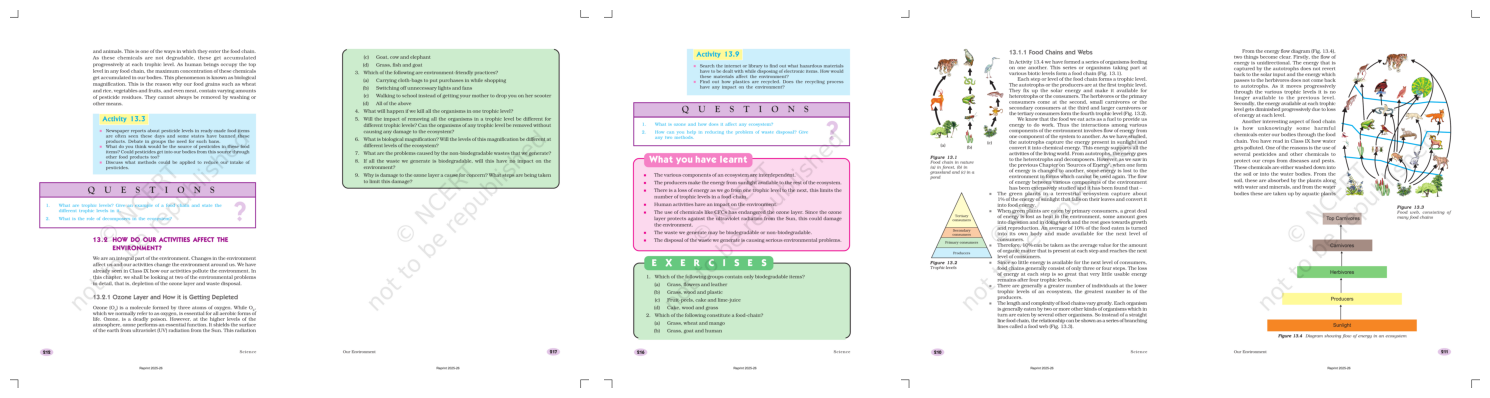

In [21]:
display_image_grid(matched_images)

### Inference (via `Ollama`)

In [22]:
def convert_pil_to_base64(pil_image):
    buffered = BytesIO()
    pil_image.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return img_str

image_list = [convert_pil_to_base64(item) for item in matched_images]

In [23]:
# use ollama to generate the response from the matched images and the query
model = ollama.generate(model="llava", prompt=query_text, images=image_list)

In [24]:
Markdown(model.response)

 In the image, you have a textbook page discussing trophic levels in an ecosystem. The title "Activity II: Chains and Webs" is at the top left corner. The diagram illustrates the food chain of a given ecosystem, which includes a plant at the base (producer), herbivores (primary consumers), carnivores (secondary consumers), and other tertiary consumers or omnivorous species (top predators).

The textbook page contains an exercise on food chains with multiple questions to be answered. The first question asks what happens in the ecosystem if one of the animals that is at the top of the food chain dies out. The second question poses a hypothetical scenario where some people are affected by something happening to animals, and there's a word puzzle asking you to determine which animal is the main consumer in the given diagram.

The bottom part of the image displays an exercise asking if it's possible to use different trophic levels or how the trophic levels could be changed. The textbook page appears to be from a learning resource or study aid, and it serves as an educational tool for students studying ecosystems and food chains. 

### Inference (via `Bedrock`)

In [25]:
def read_and_encode_image(image_path: str):

    with open(image_path, 'rb') as image_file:
        image_bytes = image_file.read()
        
    image_format = Image.open(image_path).format.lower()

    message_content = {
                    "image": {
                        "format": image_format,
                        "source": {"bytes": image_bytes},
                    }
                }
    
    return message_content


def send_images_to_model_using_converse(matched_items: list, query: str, model_id: str):

    system_prompt = 'You are a helpful assistant for question answering. Given the context, answer the question. Do not include any other text than the answer.'

    image_list = []
    for image_path in matched_items:
        image_list.append({
            "image_path": image_path, 
        })

    content_list = []
    for img in image_list:
        message_content = read_and_encode_image(img['image_path'])
        content_list.append(message_content)
    
    content_list.append({"text": query})
    system = [ { "text": system_prompt } ]
    
    # Define a "user" message including both the image and a text prompt.
    messages = [
        {
            "role": "user",
            "content": content_list,
        }
    ]
    
    # Configure the inference parameters.
    inf_params = {"temperature": .3, "maxTokens": 5000}
    
    # Initialize the Bedrock client
    client = boto3.client('bedrock-runtime', region_name='us-east-1')

    response = client.converse(
        modelId=model_id, 
        messages=messages,
        system=system, 
        inferenceConfig=inf_params
    )

    return response

In [26]:
model_id = "us.anthropic.claude-3-7-sonnet-20250219-v1:0"
response = send_images_to_model_using_converse(matched_items=matched_images_path, query=query_text, model_id=model_id)


In [27]:
Markdown(response['output']['message']['content'][0]['text'])

Trophic levels are the feeding positions in a food chain. They include:

1. Producers (first trophic level) - green plants that capture solar energy and convert it to food energy
2. Primary consumers (second trophic level) - herbivores that eat plants
3. Secondary consumers (third trophic level) - small carnivores that eat herbivores
4. Tertiary consumers (fourth trophic level) - larger carnivores at the top of the food chain

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Building an Multimodal Agentic RAG System
</h1>

# `Data Ingestion`

<p align="center">
  <img src="imgs/1.png" alt="Multimodal Diagram">
</p>


# `RAG Pipeline`

<p align="center">
  <img src="imgs/2.png" alt="Multimodal Diagram">
</p>


# 



































<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Building an Multimodal Agentic RAG using phoenix Agents
</h1>

<p align="center">
  <img src="imgs/3.png" alt="Multimodal Diagram">
</p>


### Creating `Custom Tools` for phoenix Agents

In [28]:
from strands import Agent, tool

# Create a Retrieval Custom Tool 
@tool
def retrieve_from_qdrant(query: str):
    """
    Retrieve the most relevant documents from Qdrant vector database
    based on the given text query.
    
    Args:
        query (str): The user query to search in the knowledge base.
    
    Returns:
        list: List of paths to the matched images.
    """
    global client, COLLECTION_NAME, colpali_processor, colpali_model

    print(f"🔍 Retrieving documents for query: {query}")
    
    with torch.no_grad():
        text_embedding = colpali_processor.process_queries([query]).to(colpali_model.device)  
        text_embedding = colpali_model(**text_embedding)

    token_query = text_embedding[0].cpu().float().numpy().tolist()
    start_time = time.time()

    # Perform search in Qdrant
    query_result = client.query_points(
        collection_name=COLLECTION_NAME,
        query=token_query,
        limit=5,
        search_params=models.SearchParams(
            quantization=models.QuantizationSearchParams(
                ignore=True,
                rescore=True,
                oversampling=2.0
            )
        )
    )

    print(f"⏳ Query Time: {(time.time()-start_time):.3f} s")

    matched_images_path = []

    # Define a folder to save matched images
    MATCHED_IMAGES_DIR = "matched_images"
    
    # Delete all files and the directory itself if it exists
    if os.path.exists(MATCHED_IMAGES_DIR):
        shutil.rmtree(MATCHED_IMAGES_DIR)

    os.makedirs(MATCHED_IMAGES_DIR)
    
    for result in query_result.points:
        doc_id = result.payload["doc_id"]
        page_num = result.payload["page_num"]

        for item in dataset:
            if item["doc_id"] == doc_id and item["page_num"] == page_num:
                image_filename = os.path.join("matched_images", f"match_doc_{doc_id}_page_{page_num}.png")
                item["image"].save(image_filename, "PNG")
                matched_images_path.append(image_filename)

                print(f"Saved: {image_filename}")
                break  

    print("\n All matched images are saved in the 'matched_images' folder.")
    
    return matched_images_path

### Defining the `Model` 

In [30]:
from strands import Agent
from strands.models import BedrockModel
from strands.models.ollama import OllamaModel

from strands_tools import image_reader

In [31]:
#  Define the Ollama Model
model_ollama = OllamaModel(
    host="http://localhost:11434",
    model_id="llama3.2:latest",
)

# Define the Bedrock Model
model_bedrock = BedrockModel(
    model_id="us.anthropic.claude-3-7-sonnet-20250219-v1:0",
    max_tokens=64000
)



In [32]:
system_prompt = """
You are an intelligent academic assistant named *Retrieval Agent*, designed to help students by retrieving the most relevant educational content from a structured knowledge base.

Your primary responsibilities are:
- To interpret the student's natural language query and understand the intent.
- To retrieve the most relevant **textbook pages, images, or diagrams** from the NCERT Class X Science knowledge base.
- Use your tools effectively: 
  - `retrieve_from_qdrant` for semantic search across documents and image metadata.
  - `image_reader` to extract text or captions from images, if needed for query interpretation.

Guidelines:
- You MUST return only the most relevant documents, images, or pages — prioritize **clarity, precision, and relevance**.
- If the query is ambiguous, use your understanding to infer the most probable topic (e.g., "How do lenses form images?" should focus on *light chapter diagrams*).
- Do NOT fabricate answers or try to explain concepts — your job is strictly to **retrieve**, not interpret or reason.
- Return the content as a list of file paths or image encodings that can be passed to a reasoning agent.

Your tone should remain academic and neutral. Ensure your output is concise, well-formatted, and structured to assist the next step in the pipeline (e.g., an answering or multimodal reasoning agent).

Example Input:
> "Explain the difference between concave and convex lenses with diagrams."

Example Output:
> ["images/fig2.png", "images/fig1.png"]
"""

### Create the `Agent` 

In [33]:
# 2. Define the Agent 
retrieval_agent = Agent(model=model_bedrock, 
                        system_prompt=system_prompt, 
                        tools=[retrieve_from_qdrant, image_reader])


### Send the `Query`

In [34]:
# 3. Send the query to the Agent
query_text = "What are the different Trophic levels"
response = retrieval_agent(query_text)

Markdown(response.message['content'][0]['text'])

I'll retrieve the most relevant content about trophic levels from the NCERT Class X Science knowledge base. Let me search for that information for you.
Tool #1: retrieve_from_qdrant
🔍 Retrieving documents for query: trophic levels food chain ecosystem
⏳ Query Time: 0.015 s
Saved: matched_images/match_doc_0_page_3.png
Saved: matched_images/match_doc_0_page_2.png
Saved: matched_images/match_doc_0_page_4.png
Saved: matched_images/match_doc_0_page_8.png
Saved: matched_images/match_doc_0_page_9.png

 All matched images are saved in the 'matched_images' folder.
I've retrieved several relevant pages from the textbook that contain information about trophic levels. These images contain diagrams and explanations of the different trophic levels in ecosystems and food chains. Here are the most relevant materials:

1. matched_images/match_doc_0_page_3.png
2. matched_images/match_doc_0_page_2.png
3. matched_images/match_doc_0_page_4.png
4. matched_images/match_doc_0_page_8.png
5. matched_images/matc

I've retrieved several relevant pages from the textbook that contain information about trophic levels. These images contain diagrams and explanations of the different trophic levels in ecosystems and food chains. Here are the most relevant materials:

1. matched_images/match_doc_0_page_3.png
2. matched_images/match_doc_0_page_2.png
3. matched_images/match_doc_0_page_4.png
4. matched_images/match_doc_0_page_8.png
5. matched_images/match_doc_0_page_9.png

These pages should provide comprehensive information about the different trophic levels, their definitions, examples, and their relationships within food chains and ecosystems.

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Adding Voice Capability
</h1>

<p align="center">
  <img src="imgs/4.png" alt="Multimodal Diagram">
</p>


<!-- <p align="center">
  <img src="imgs/multimodal.png" alt="Multimodal Diagram">
</p>
 -->

### Adding `Voice` Capability

In [35]:
from strands_tools import speak

In [36]:
system_prompt = """
You are an intelligent academic assistant named *Retrieval Agent*, designed to help students by retrieving the most relevant educational content from a structured knowledge base.

Your primary responsibilities are:
- To interpret the student's natural language query and understand the intent.
- To retrieve the most relevant **textbook pages, images, or diagrams** from the NCERT Class X Science knowledge base.
- Generate the response in the form of a text and also speak the answer to the user.
- Use your tools effectively: 
  - `retrieve_from_qdrant` for semantic search across documents and image metadata.
  - `image_reader` to extract text or captions from images, if needed for query interpretation.
  - `speak` to speak the answer to the user.   

Guidelines:
- You MUST return only the most relevant documents, images, or pages — prioritize **clarity, precision, and relevance**.
- If the query is ambiguous, use your understanding to infer the most probable topic (e.g., "How do lenses form images?" should focus on *light chapter diagrams*).
- Do NOT fabricate answers or try to explain concepts — your job is strictly to **retrieve**, not interpret or reason.
- Return the content as a list of file paths or image encodings that can be passed to a reasoning agent.

Your tone should remain academic and neutral. Ensure your output is concise, well-formatted, and structured to assist the next step in the pipeline (e.g., an answering or multimodal reasoning agent).

Example Input:
> "Explain the difference between concave and convex lenses with diagrams."

Example Output:
> ["images/fig1.png", "images/fig2.png"]
"""

### Create the `Agent` and send the `Query`

In [37]:
# Define the Retrieval Agent 
retrieval_agent_with_voice = Agent(model=model_bedrock, 
                                   system_prompt=system_prompt, 
                                   tools=[retrieve_from_qdrant, image_reader, speak])

In [38]:
retrieval_agent_with_voice(query_text)

I'll help you find information about trophic levels from the NCERT Class X Science knowledge base. Let me search for the most relevant content.
Tool #2: retrieve_from_qdrant
🔍 Retrieving documents for query: trophic levels food chain ecosystem
⏳ Query Time: 0.011 s
Saved: matched_images/match_doc_0_page_3.png
Saved: matched_images/match_doc_0_page_2.png
Saved: matched_images/match_doc_0_page_4.png
Saved: matched_images/match_doc_0_page_8.png
Saved: matched_images/match_doc_0_page_9.png

 All matched images are saved in the 'matched_images' folder.
I've found some relevant content about trophic levels from your textbook. Let me examine the first image to ensure it contains the information you're looking for:
Tool #3: image_reader


Let me also check the second image to get more information about trophic levels:
Tool #4: image_reader
Perfect! I now have detailed information about trophic levels from your NCERT Class X Science textbook. Let me prepare a response about the different trophi

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Parameter  ┃ Value                                                 ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Mode       │ fast                                                  │
│ Text       │ Trophic levels are the different feeding positions... │
│ Play Audio │ True                                                  │
└────────────┴───────────────────────────────────────────────────────┘

Output()

╭──────────────────────────────────────────────────── Success ────────────────────────────────────────────────────╮
│ 🗣️ Text spoken using macOS say command                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

AgentResult(stop_reason='end_turn', message={'role': 'assistant', 'content': []}, metrics=EventLoopMetrics(cycle_count=5, tool_metrics={'retrieve_from_qdrant': ToolMetrics(tool={'toolUseId': 'tooluse_uWQ-GX1kSN-Lw1soZV8lWQ', 'name': 'retrieve_from_qdrant', 'input': {'query': 'trophic levels food chain ecosystem'}}, call_count=1, success_count=1, error_count=0, total_time=0.6729710102081299), 'image_reader': ToolMetrics(tool={'toolUseId': 'tooluse_f-kyHVkOSQC_G_z5yZgwmA', 'name': 'image_reader', 'input': {'image_path': 'matched_images/match_doc_0_page_2.png'}}, call_count=2, success_count=2, error_count=0, total_time=0.0036296844482421875), 'speak': ToolMetrics(tool={'toolUseId': 'tooluse_cRdscYeLRbSuP7fb9p4zaQ', 'name': 'speak', 'input': {'text': 'Trophic levels are the different feeding positions in a food chain, showing how energy flows through an ecosystem. According to the NCERT Class X Science textbook, there are typically four main trophic levels:\n\nThe first trophic level consi

<h1 style="background: linear-gradient(to right, #ff6b6b, #4ecdc4); 
           color: white; 
           padding: 20px; 
           border-radius: 10px; 
           text-align: center; 
           font-family: Arial, sans-serif; 
           text-shadow: 2px 2px 4px rgba(0,0,0,0.5);">
  Thank you.
</h1>.